In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from sklearn.metrics import mean_squared_error

import pickle
import time

from IPython.display import clear_output

from utils import get_views_coord
from utils import test_val_train
from utils import sample_conflict_timeline

from utils import get_hyper_priors

start_time = time.time()

Todo:

1) Make sure that predictions can be merged back to data frame 
    -> but is that even relevant before we get to the predictions? Where it is arguebly a bit easier...

2) Change it so you predict for all time lines (at least C>0) no matter what you train on.   
3) Move functions to Util.
4) Make final classifier
4) Make ready to run eksperiments on comuterome.   

Bonus) Also don't forget you only do sb right now. Would be nice to also have ns and os.

Q's) 
- why don't they use 1989 for train?
- Don't they say 36 months? But there are only 36 in train and val? Is that because they say 36 months into the furture? 



old note (maybe still relevatn):
So, you wnat to make it as a function that can by iterated over, shitching C and shortterm cov - and maybe even priors. It needs to give out mse and save it. You also need to be able to survey/plot the models you afterwards find most interesting.

In [2]:
# get df:
df = get_views_coord()

# get train and val/test id:
train_id, val_id = test_val_train(df)
#train_id, test_id = test_val_train(df, test_time = True)

# X, y, X_test, y_test, idx, idx_test = sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C = 100, N = None, get_index= True)

Train from 1/1990 trough 12/2011 (264)
Val from 1/2012 trough 12/2014 (36)
Test time from 1/2015 trough 12/2017 (36)
(Test=False, so test set not outputted)



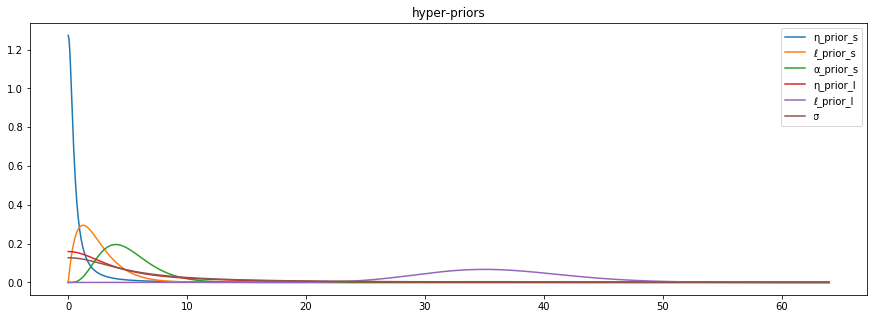

In [3]:
hyper_priors_dict = get_hyper_priors(plot = True)

In [4]:
# 43.3 minutes with 148 time-lines
C = 100 # -> 6 obs
# C = 64 # -> 12 obs
# C = 40 # -> 38 obs
# C = 32 # -> 60 obs
# C = 24 # -> 87 obs
# C = 16 # -> 158 obs

N=None
seed = 42
dem = False

hps = get_hyper_priors(plot = False)

with pm.Model() as model:

    # short term trend/irregularities ---------------------------------
    ℓ_s = pm.Gamma("ℓ_s", alpha=hps['ℓ_alpha_s'] , beta=hps['ℓ_beta_s'])
    η_s = pm.HalfCauchy("η_s", beta=hps['η_beta_s'])
    α_s = pm.Gamma("α_s", alpha=hps['α_alpha_s'], beta=hps['α_beta_s']) #for Rational Quadratic Kernel. Ignore for Quad or Matern 

    # mean and kernal for short term trend
    mean_s =  pm.gp.mean.Zero()
    #cov_s = η_s ** 2 * pm.gp.cov.RatQuad(1, ℓ_s, α_s) # this seems to help alot when you split the trends below
    cov_s = η_s ** 2 * pm.gp.cov.ExpQuad(1, ℓ_s) # this seems to help alot when you split the trends below
    # so this needs to be some thng you can vary over in a loop

    # GP short term trend 
    gp_s = pm.gp.Marginal(mean_func = mean_s, cov_func=cov_s)


    # long term trend -------------------------------------------------
    ℓ_l = pm.Gamma("ℓ_l", alpha=hps['ℓ_alpha_l'] , beta=hps['ℓ_beta_l'])
    η_l = pm.HalfCauchy("η_l", beta=hps['η_beta_l'])
    
    # mean and kernal for long term trend
    mean_l =  pm.gp.mean.Zero()
    cov_l = η_l **2 * pm.gp.cov.ExpQuad(1, ℓ_l) # Cov func.
    
    # GP short term trend 
    gp_l = pm.gp.Marginal(mean_func = mean_l, cov_func=cov_l)


    # noise (constant "white noise") -----------------------------------
    σ = pm.HalfCauchy("σ", beta=hps['σ_beta'])


    # sample and split X,y ---------------------------------------------  
    X, y, _, _ = sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C = 100, N = None)

    # Full GP ----------------------------------------------------------
    gp = gp_s + gp_l

    # sample:
    for i in range(y.shape[1]):
        
        print(f'Time-line {i+1}/{y.shape[1]} in the works...') # why does it not print?
        clear_output(wait=True)

        y_ = gp.marginal_likelihood(f'y_{i}', X=X[:,i][:,None], y=y[:,i], noise= σ)
        
    
    mp = pm.find_MAP()


In [5]:
pd.DataFrame(
    {
        "Parameter": ["ℓ_s", "η_s", "α_s", "ℓ_l", "η_l", "σ"],
        "Value at MAP": [float(mp["ℓ_s"]), float(mp["η_s"]), float(mp["α_s"]), float(mp["ℓ_l"]), float(mp["η_l"]), float(mp["σ"])],
    }
)

,Parameter,Value at MAP
0,ℓ_s,2.690282
1,η_s,0.524803
2,α_s,3.999615
3,ℓ_l,35.393876
4,η_l,1.300028
5,σ,0.914842


In [6]:
end_time = time.time()
run_time = end_time - start_time

string = f'Run for {run_time/60:.3} minutes with {y.shape[1]} time-lines'
print(string)

Run for 2.14 minutes with 6 time-lines


In [7]:
def predict(forecast_months = 36, gp_s = gp_s, gp_l = gp_l, gp = gp, σ = σ, demean = dem):
    
    X, y, X_test, y_test, idx, idx_test = sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C = 100, N = None, get_index= True)

    df_train = pd.DataFrame({'id' : idx.reshape(-1,), 'X' : X.reshape(-1,), 'y' : y.reshape(-1,)})
    df_test = pd.DataFrame({'id' : idx_test.reshape(-1,), 'X' : X_test.reshape(-1,), 'y' : y_test.reshape(-1,)})

    df_new = pd.concat([df_train, df_test]) # you could but in a binary for train/val/test
    X_new = df_new['X'].unique()[:,None]

    mu_list = []
    mu_s_list = []
    mu_l_list = []
    var_list = []
    var_s_list = []
    var_l_list = []

    for i in range(y.shape[1]):

        mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)
        mu_s, var_s = gp_s.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)
        mu_l, var_l = gp_l.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)

        mu_list.append(mu)
        mu_s_list.append(mu_s)
        mu_l_list.append(mu_l)
        var_list.append(var)
        var_s_list.append(var_s)
        var_l_list.append(var_l)

    df_new['mu'] = np.array(mu_list).flatten('F') # this flatten seems to work
    df_new['mu_s'] = np.array(mu_s_list).flatten('F') # this flatten seems to work
    df_new['mu_l'] = np.array(mu_l_list).flatten('F') # this flatten seems to work
    df_new['var'] = np.array(var_list).flatten('F') # this flatten seems to work
    df_new['var_s'] = np.array(var_s_list).flatten('F') # this flatten seems to work
    df_new['var_l'] = np.array(var_l_list).flatten('F') # this flatten seems to work

    return(df_new)

In [8]:
df_new = predict()


X: (264, 6), y: (264, 6) 
X (val/test): (36, 6), y (val/test): (36, 6) 



In [9]:
df_merged = pd.merge(df_new, df[['id', 'pg_id']], how = 'left', on = 'id') # Should merge all but this is fine for now.

In [10]:
def plot_predicttions(df = df_merged):


    fig = plt.figure(figsize=(20, 8))
    colors = sns.color_palette("hls", 6)

    for i,j in enumerate(df_merged['pg_id'].unique()):

        X = df_merged[df_merged['pg_id'] == j]['X']
        y = df_merged[df_merged['pg_id'] == j]['y']
        mu = df_merged[df_merged['pg_id'] == j]['mu']
        mu_s = df_merged[df_merged['pg_id'] == j]['mu_s']
        mu_l = df_merged[df_merged['pg_id'] == j]['mu_l']
        sd = np.sqrt(df_merged[df_merged['pg_id'] == j]['var'])
        sd_s = np.sqrt(df_merged[df_merged['pg_id'] == j]['var_s'])
        sd_l = np.sqrt(df_merged[df_merged['pg_id'] == j]['var_l'])

        plt.plot(X, mu,'-', color = colors[i])
        plt.plot(X, mu_s,'-', color = colors[i])
        plt.plot(X, mu_l,'-', color = colors[i])

        plt.plot(X.iloc[:-36], y.iloc[:-36],'o', color = colors[i])
        plt.plot(X.iloc[-36:], y.iloc[-36:],'x', color = colors[i])


        # This is old and not implimented yet.
        plt.plot(X, mu + 2 * sd, "-", lw=1, color=colors[i], alpha=0.5)
        plt.plot(X, mu - 2 * sd, "-", lw=1, color=colors[i], alpha=0.5)
        plt.fill_between(X, mu - 2 * sd, mu + 2 * sd, color=colors[i], alpha=0.2)

        plt.plot(X, mu_s + 2 * sd_s, "-", lw=1, color=colors[i], alpha=0.5)
        plt.plot(X, mu_s - 2 * sd_s, "-", lw=1, color=colors[i], alpha=0.5)
        plt.fill_between(X, mu_s - 2 * sd_s, mu_s + 2 * sd_s, color=colors[i], alpha=0.2)

        plt.plot(X, mu_l + 2 * sd_l, "-", lw=1, color=colors[i], alpha=0.5)
        plt.plot(X, mu_l - 2 * sd_l, "-", lw=1, color=colors[i], alpha=0.5)
        plt.fill_between(X, mu_l - 2 * sd_l, mu_l + 2 * sd_l, color=colors[i], alpha=0.2)


    plt.vlines(df_merged['X'].max()-36, -1, 8, linestyles='dashed', color = 'red', alpha = 0.5)

    plt.show()


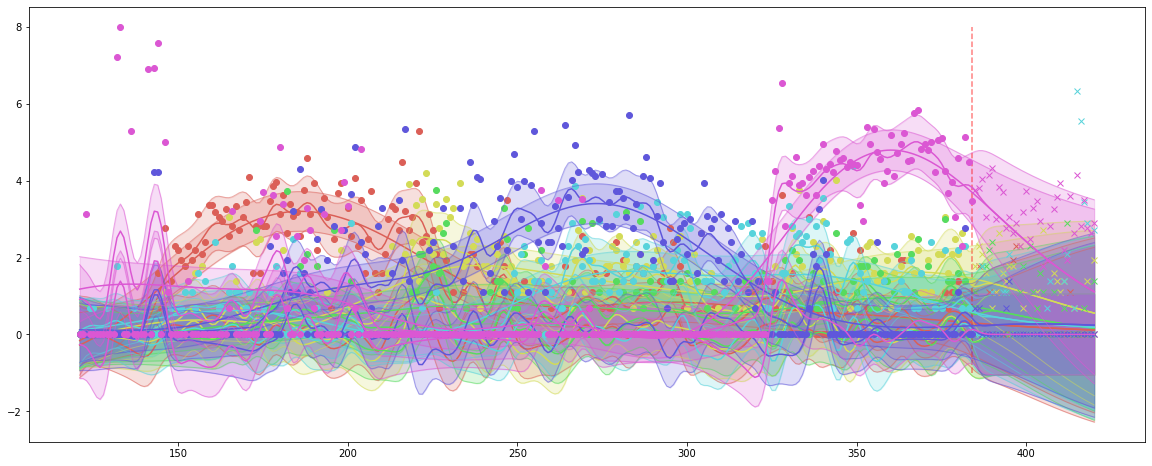

In [11]:
plot_predicttions()

# old stuff not yet salvaged

In [ ]:
def get_mse(mu_list, y_val = y_val):

    mse_list = []
    mu = np.array(mu_list)

    for i in range(y_val.shape[1]):

        true = y_val[:,i]
        pred = np.array(mu_list)[i,-y_val.shape[0]:] #takes the last predictions corrospoding to the val set
        mse_list.append(mean_squared_error(true, pred))

    mse_mean = np.array(mse_list).mean()
    mse_std = np.array(mse_list).std()

    return(mse_list, mse_mean, mse_std)


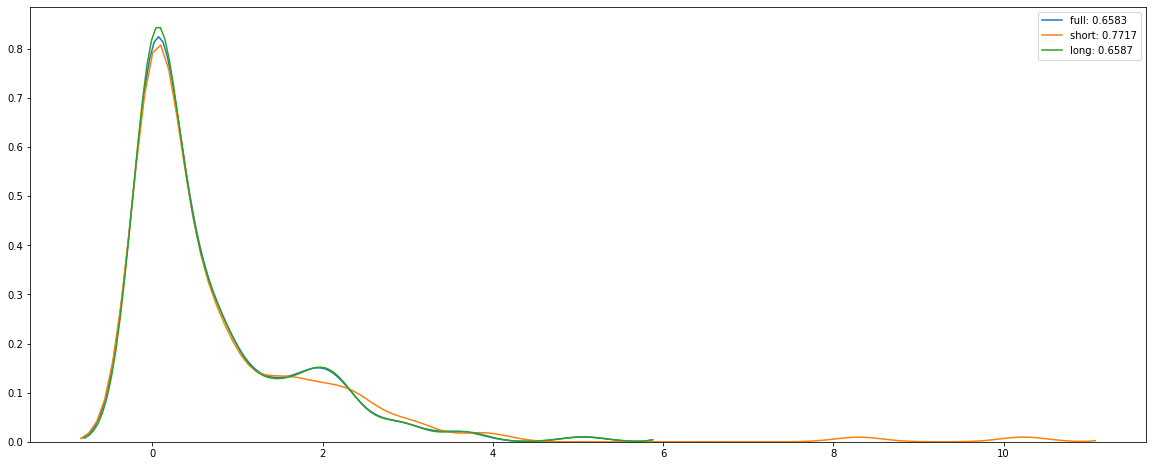

In [16]:
# make this a funciton adn get it to util.

mse, mse_mean, mse_std = get_mse(preds['mu_list'])
mse_s, mse_mean_s, mse_std_s = get_mse(preds['mu_s_list'])
mse_l, mse_mean_l, mse_std_l = get_mse(preds['mu_l_list'])

fig = plt.figure(figsize=(20, 8))

sns.kdeplot(mse, label = f'full: {mse_mean:.4}' )
sns.kdeplot(mse_s, label = f'short: {mse_mean_s:.4}')
sns.kdeplot(mse_l, label = f'long: {mse_mean_l:.4}')

plt.show()

In [17]:
# demeaning is not dead yet... You should already now try out with a simple ensample classifier or some thing in the end - train as you fight.. 

# And full is doing quite well, when you start to include more time lines (but in this case, it is also becouae it did not split short and long corectly...)..

# importantly you also need to predict time lines that where not even in the trainset...

# Squad Ex kernel for short term is fine with more observaitons (C = 32 -> N = 55  )
# Also Squad Ex kernel for short term is fine with more observaitons (C = 24 -> N = 85  )

# the fact that lenghtscale_short changes so much as a funciton of C is a good justification, but then it also needs to work.